# Checkpoint 2: Mandatory Check-In

- Research Questions (1.5%).
- Feature Engineering (2%).
- Modeling Approaches (3%).
- Preliminary Results (1%).


In [1]:
import zipfile
import numpy as np
import re
import io
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from data_utils import read_files_from_zip
from feature_utils import crop_and_fill
from eda_utils import show_image


#%load_ext memory_profiler
#from importlib import reload
#reload(data_utils)

## Import data

In [2]:
!ls ../Data

processed_test.pkl   README.md		     sp24_grad_project_data.zip
processed_train.pkl  sp24_grad_project_data


In [3]:
%%time
# Check if our pickles files already exist.
if (os.path.exists('../Data/processed_train.pkl') & os.path.exists('../Data/processed_test.pkl')):
    PICKLED = True
    train_df = pd.read_pickle("../Data/processed_train.pkl")
    test_df = pd.read_pickle("../Data/processed_test.pkl")
else: 
    PICKLED = False

PICKLED

CPU times: user 665 ms, sys: 2.47 s, total: 3.13 s
Wall time: 4.89 s


True

In [4]:
%%time
PICKLED = False
if not PICKLED:
    # Set Date Source
    data_file = '../Data/sp24_grad_project_data.zip'
    
    # Load Test Images
    test_data_images = read_files_from_zip(data_file, r'(test)_images_([\w-]*)\.npz')
    
    # Load Train Images and Labels
    train_data_images = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_images\.npz')
    train_data_labels = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_labels\.npy')

Importing data from zip: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Found the following datasets:  ['hurricane-matthew', 'flooding-fire']


Importing data from zip: 100%|██████████| 3/3 [00:13<00:00,  4.66s/it]


Found the following datasets:  ['socal-fire', 'midwest-flooding', 'hurricane-matthew']


Importing data from zip: 100%|██████████| 3/3 [00:00<00:00, 439.50it/s]

Found the following datasets:  ['socal-fire', 'midwest-flooding', 'hurricane-matthew']
CPU times: user 15 s, sys: 1.34 s, total: 16.3 s
Wall time: 16.9 s


## Data Cleansing

There are many potential enhancements, this seems a reasonable starting point.

Set the output size to match ResNet50 default, 180x180. If the original image is smaller, scale it ~~preserving the aspect ratio~~, noised with random pixels from the original image, and with unscaled original centered. If it’s larger, a random crop is performed.  Black pixels are replaces with random non-black pixels to address images with missing pixels.

Todo: Think about adding features indicating whether an image has been cropped or has a scaled background.
Most of the larger images are those with no damaged, so they’re not a major concern. 

In [5]:
%%time

def preprocess_images(image_data_set):
    """
    Preprocess image data, modifies image in place to conserve memory.
    """
    for key in image_data_set.keys():
        print(f'Processing {key} images:')
        
        for i in tqdm(range(len(image_data_set[key]['images']))):
            image_data_set[key]['images'][i] = crop_and_fill(image_data_set[key]['images'][i], 180, background='scaled', replace_scaled=0.2)
"""
# not so fast
if not PICKLED:
    preprocess_images(train_data_images)
    preprocess_images(test_data_images)
"""

CPU times: user 32 µs, sys: 0 ns, total: 32 µs
Wall time: 40.1 µs


'\n# not so fast\nif not PICKLED:\n    preprocess_images(train_data_images)\n    preprocess_images(test_data_images)\n'

dict_keys(['socal-fire', 'midwest-flooding', 'hurricane-matthew'])


(144, 195, 3)

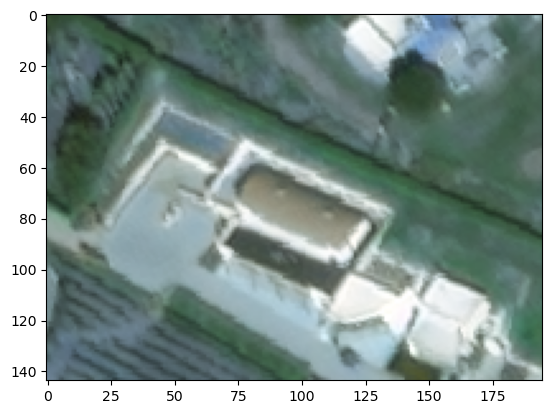

In [6]:
# How did we do?
# Show a image sample
if not PICKLED:
    print(train_data_images.keys())
    image = train_data_images['socal-fire']['images'][0]
    display(image.shape)
    show_image(image)
    plt.show()

## Prepare our data for pickling

In [7]:
# len(test_data_images), len(train_data_images), len(train_data_labels)

In [8]:
type(train_data_images['socal-fire']['images'][0])

numpy.ndarray

In [9]:
PICKLED = False
def data2pd(image_dataset, label_dataset=None):
    # replace type with disaster type
    for key in image_dataset.keys():
        #print(key)
        regex = r'(?:fire|flood|hurricane)'
        matches = re.findall(r'(fire|flood|hurricane)', key)
        disaster_type = matches[0] if matches else None
        image_dataset[key]['type'] = disaster_type
        if label_dataset != None:
            image_dataset[key]['labels'] = label_dataset[key]['labels'] # add labels
    
    df = pd.DataFrame(image_dataset)
    if label_dataset != None:
        df = df.T.explode(['images', 'labels']).drop(columns = ['file']).rename(columns={'labels':'label', 'images':'image'})
    else:
        df = df.T.explode(['images']).drop(columns = ['file']).rename(columns={'images':'image'})
    return df.reset_index()

if not PICKLED:
    train_df = data2pd(train_data_images, train_data_labels)
    test_df = data2pd(test_data_images)

## Data split and augmentation plan (Disaster Type Classification)

We'll use a mix of oversampling and undersampling...

 - oversample the minority class using replacement
 - undersample by randomly delete rows from the majority class to match
 - think about how to use Neighborhood Cleaning Under Sampling...
   
 - Validation:
     - Sample without replacement 8 samples of each disaster type/level
 - Training:
     - fire:3 has the most (1064-8) representation,
     - flood:1 the next largest (114-8) representation and
     - fire:2 has the least (43-8).

In [10]:
# Add a size column for the orginal image size
def get_size(img):
    dim = img.shape
    return dim[0] * dim[1]
train_df['size'] = train_df['image'].apply(get_size)

print(train_df.columns)
train_df[['size']].describe().T

Index(['index', 'type', 'image', 'label', 'size'], dtype='object')


,count,mean,std,min,25%,50%,75%,max
size,26535.0,8169.871867,12364.717747,84.0,1936.0,4340.0,10240.0,410464.0


In [38]:
# Create dataset for Disaster Type Classification
classify_type_df = train_df[(train_df.type == 'fire') | (train_df.type == 'flood')]
count_s = classify_type_df.groupby('type')['label'].value_counts()
display(count_s)

# Drop size outliers from over represented columns...
# no damage and fire_3
classify_type_df = classify_type_df.drop(
    classify_type_df[ (classify_type_df['label']==0) & ((classify_type_df['size'] > 10240) | (classify_type_df['size'] < 1936))  ].index
)

classify_type_df = classify_type_df.drop(
    classify_type_df[ (classify_type_df['label']==3) & (classify_type_df['type']=='fire') & ((classify_type_df['size'] > 10240) | (classify_type_df['size'] < 1936))  ].index
)

count_s = classify_type_df.groupby('type')['label'].value_counts()
display(count_s)

type   label
fire   0        7204
       3        1064
       1          69
       2          43
flood  0        6734
       1         114
       2          97
       3          59
Name: count, dtype: int64

type   label
fire   0        2562
       3         477
       1          69
       2          43
flood  0        3616
       1         114
       2          97
       3          59
Name: count, dtype: int64

In [39]:
# Create validation set for modelling.

# We would like for our test set to representive
# of our population so we'll limit it
# sizes in the innerquartile.

sample_size = 8

classify_type_valid_df = pd.DataFrame()
print('Before: ',classify_type_df.shape)
for T in classify_type_df.type.unique():
    for L in classify_type_df.label.unique():
        #print(f'{T}:{L}')
        if (L==0):
            this_sample_size = sample_size//2
        else:
            this_sample_size = sample_size
        sample_df =  classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)
        & ((classify_type_df['size'] <= 10240) & (classify_type_df['size'] >= 1936)) 
        ].sample(this_sample_size)
        #display(sample_df.shape)
        #print(type(sample_df))
        classify_type_valid_df = pd.concat([sample_df, classify_type_valid_df])
# drop our test sample from the parent df
classify_type_df = classify_type_df.drop(index=classify_type_valid_df.index)       

print('After: ',classify_type_df.shape)
assert(6981 == classify_type_df.shape[0]), 'Invalid parent data size, something looks fishy.'

Before:  (7037, 5)
After:  (6981, 5)


In [40]:
from feature_utils import augment_image

# Now augment data until balanced.
# We'll use a mix of oversampling and undersampling...
# - oversample the minority class using replacement
# - undersample by randomly delete rows from the majority class to match

classify_type_train_df = pd.DataFrame()

# Set a reasonable argumentation limit
sample_size = 150 #int(114 * 1.32)

# We apply flip, rotate augmentation to the
# sample with replacement samples.
# We might duplicate an augmentation if the
# same record is sampled and the augmentation
# is applied.
# Anyway... Cool thing is that we can get as many unique
# balanced training sets as we desire.

for T in classify_type_df.type.unique():
    for L in classify_type_df.label.unique():
        if L==0:
            this_sample_size = sample_size//2
        else:
            this_sample_size = sample_size
        record_size = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].shape[0]
        if (record_size > this_sample_size):
            sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].sample(this_sample_size)
        else:
            sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)]
            classify_type_train_df = pd.concat([sample_df, classify_type_train_df])
            sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].sample(this_sample_size-record_size, replace=True)
            sample_df['image'] = sample_df['image'].apply(augment_image)
        classify_type_train_df = pd.concat([sample_df, classify_type_train_df])
count_s = classify_type_train_df.groupby('type')['label'].value_counts()
display(count_s)

type   label
fire   1        150
       2        150
       3        150
       0         75
flood  1        150
       2        150
       3        150
       0         75
Name: count, dtype: int64

In [41]:
# Now let's recap our datasets for task A

def show_balance(df):
    display(df.groupby('type')['label'].value_counts())

show_balance(classify_type_valid_df)
show_balance(classify_type_train_df)

type   label
fire   1        8
       2        8
       3        8
       0        4
flood  1        8
       2        8
       3        8
       0        4
Name: count, dtype: int64

type   label
fire   1        150
       2        150
       3        150
       0         75
flood  1        150
       2        150
       3        150
       0         75
Name: count, dtype: int64

## Data split and augmentation plan (Disaster Level Classification)

We'll use a mix of oversampling and undersampling...
 - oversample the minority class using replacement
 - undersample by randomly delete rows from the majority class to match

 - Validation:
    - Sample without replacement N samples of each disaster level
 - Training:
    - Select a sample size such that is a balance between drop/augment

In [15]:
# Create dataset for Disaster Type Classification

# This dataset is a bit more balanced.
classify_level_df = train_df[(train_df.type == 'hurricane')]
show_balance(classify_level_df)

"""
# Drop size outliers from over represented columns...
# We account for this below now...
classify_level_df = classify_level_df.drop(
    classify_level_df[ (classify_level_df['label']==1) & ((classify_level_df['size'] > 10240) | (classify_level_df['size'] < 1936))  ].index
)

show_balance(classify_level_df)
""";

type       label
hurricane  1        5236
           0        2631
           3        1740
           2        1544
Name: count, dtype: int64

In [16]:
# Find a good validation split size
# We'll pick a whole number for our puny human brains.
validation_sample_size = int(classify_level_df.groupby('type')['label'].value_counts().min() * .1945)
print(validation_sample_size)

300


In [17]:
# Find a good augmentation size
# We'll pick a whole number for our puny human brains.
augmentation_size = int(classify_level_df.groupby('type')['label'].value_counts().min() * 1.2955)
print(augmentation_size)

2000


In [18]:
# Create validation set for modelling.

# We would like for our test set to representive
# of our population so we'll limit it
# sizes in the innerquartile.
classify_level_valid_df = pd.DataFrame()
print('Before: ',classify_level_df.shape)
for T in classify_level_df.type.unique():
    for L in classify_level_df.label.unique():
        #print(f'{T}:{L}')
        sample_df =  classify_level_df[(classify_level_df['type'] == T) & (classify_level_df['label'] == L)
        & ((classify_level_df['size'] <= 10240) & (classify_level_df['size'] >= 1936)) 
        ].sample(validation_sample_size)
        #display(sample_df.shape)
        #print(type(sample_df))
        classify_level_valid_df = pd.concat([sample_df, classify_level_valid_df])
# drop our test sample from the parent df
classify_level_df = classify_level_df.drop(index=classify_level_valid_df.index)       

print('After: ',classify_level_df.shape)

assert(9951 == classify_level_df.shape[0]), 'Invalid parent data size, something looks fishy.'

Before:  (11151, 5)
After:  (9951, 5)


In [19]:
from feature_utils import augment_image

# Now augment data until balanced.
# We'll use a mix of oversampling and undersampling...
# - oversample the minority class using replacement
# - undersample by randomly delete rows from the majority class to match

classify_level_train_df = pd.DataFrame()

# Set a reasonable argumentation limit
sample_size = augmentation_size

# We apply flip, rotate augmentation to the
# sample with replacement samples.
# We might duplicate an augmentation if the
# same record is sampled and the augmentation
# is applied.
# Anyway... Cool thing is that we can get as many unique
# balanced training sets as we desire.

for T in classify_level_df.type.unique():
    for L in classify_level_df.label.unique():
        record_size = classify_level_df[
        (classify_level_df['type'] == T) & (classify_level_df['label'] == L)].shape[0]
        if (record_size > sample_size):
            sample_df = classify_level_df[
            (classify_level_df['type'] == T) & (classify_level_df['label'] == L)].sample(sample_size)
        else:
            sample_df = classify_level_df[
            (classify_level_df['type'] == T) & (classify_level_df['label'] == L)]
            classify_level_train_df = pd.concat([sample_df, classify_level_train_df])
            sample_df = classify_level_df[
            (classify_level_df['type'] == T) & (classify_level_df['label'] == L)].sample(
                sample_size-record_size, replace=True)
            sample_df['image'] = sample_df['image'].apply(augment_image)
        classify_level_train_df = pd.concat([sample_df, classify_level_train_df])
count_s = classify_level_train_df.groupby('type')['label'].value_counts()
display(count_s)

type       label
hurricane  0        2000
           1        2000
           2        2000
           3        2000
Name: count, dtype: int64

In [20]:
# Now let's recap our datasets for task B
show_balance(classify_level_valid_df)
show_balance(classify_level_train_df)

type       label
hurricane  0        300
           1        300
           2        300
           3        300
Name: count, dtype: int64

type       label
hurricane  0        2000
           1        2000
           2        2000
           3        2000
Name: count, dtype: int64

In [21]:
300/2000

0.15

---

In [22]:
from eda_utils import show_image

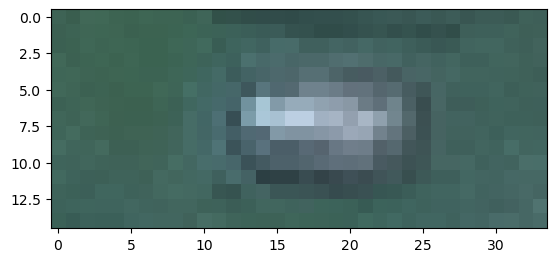

In [23]:
#train_df.iloc[0].image
show_image(classify_type_train_df.iloc[150].image)

In [24]:
%%time
"""
if not PICKLED:
    train_df.to_pickle("../Data/processed_train.pkl")
    test_df.to_pickle("../Data/processed_test.pkl")
    PICKLED = True

!ls -lh ../Data/*.pkl # Large files but this will save us loads of time.
""";

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs


In [25]:
# Free up some resources
"""
if not PICKLED:
    del(train_data_images)
    del(train_data_labels)
    del(test_data_images)
""";

For now we've only added size and used it for undersampling.
These are images so we'll let Gauss do his thing...
...try not to second guess Gauss.

## Feature Engineering

Recall our Tasks:

**Disaster Type Classification**
 -  The goal is to build a classifier that can automatically categorize images based on the type of disaster scenario, such as flooding or fire.
   
**Damage Level Classification**
 - The objective is to create a classifier that can automatically determine the level of building damage following a disaster, specifically for hurricanes.


## Modelling

Let's cookup a the simplest model we can think of...
For us this a autoencoder where we encoding our convolved image into a latent space then decode to our classes.

**Task A**
 - Reshape (180x180, normalize for positive definteness)
 - Conv2d (180x180)
 - MaxPooling2D (60x60, Dense, ReLu)
 - Dropout
 - Flatten
 - Dense (10 classes) flood or fire and levels 0-3

**Task B**
 - Reshape ((180x180, normalize for positive definteness)
 - Conv2d (180x180)
 - MaxPooling2D (60x60, Dense, ReLu)
 - Dropout
 - Flatten
 - Dense (4 classes) levels 0-3

Consider augment the data with 0-45 degree rotataton and 100to120% scaling.

In [26]:
# Recall our datasets
print(len(classify_type_valid_df), len(classify_type_train_df))
print(len(classify_level_valid_df), len(classify_level_train_df))

64 1200
1200 8000


In [27]:
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

2024-03-28 17:00:43.087380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Encode Labels

"""
#0-flood, 1-fire
classify_type_valid_df['type_code']= classify_type_valid_df['type'].apply(lambda x: 1 if x=='fire' else 0)
classify_type_train_df['type_code']= classify_type_train_df['type'].apply(lambda x: 1 if x=='fire' else 0)

# Here be the latent space...
valid_latent_labels = to_categorical(classify_type_valid_df[['type_code','label']], num_classes=10)
train_latent_labels = to_categorical(classify_type_train_df[['type_code','label']], num_classes=10)

# ...and our classifier space.
valid_labels = to_categorical(classify_type_valid_df[['type_code']], num_classes=2)
train_labels = to_categorical(classify_type_train_df[['type_code']], num_classes=2)
"""

# -1:flood, +1:fire
classify_type_valid_df['type_code'] = classify_type_valid_df[['type','label']].apply(lambda df: df['label'] if df['type']=='fire' else -df['label'], axis=1)
classify_type_train_df['type_code'] = classify_type_train_df[['type','label']].apply(lambda df: df['label'] if df['type']=='fire' else -df['label'], axis=1)

classify_type_valid_df['type_code'] = classify_type_valid_df['type_code']/classify_type_valid_df['type_code'].abs().max()
classify_type_train_df['type_code'] = classify_type_train_df['type_code']/classify_type_train_df['type_code'].abs().max()

X_train = classify_type_train_df['image'].to_list()
Y_train = classify_type_train_df['type_code']

X_valid = classify_type_valid_df['image'].to_list()
Y_valid = classify_type_valid_df['type_code']

import cv2

X_train = np.array([cv2.resize(img, (180, 180)) for img in X_train])
X_valid = np.array([cv2.resize(img, (180, 180)) for img in X_valid])

In [90]:
len(X_train), Y_train.shape

(1050, (1050,))

In [91]:
classify_type_train_df['type_code'].sample(8)

7126     1.000000
13681   -1.000000
6223     0.666667
11555   -1.000000
1840     0.333333
10170   -1.000000
13417   -0.333333
2676     0.666667
Name: type_code, dtype: float64

In [92]:
backend.clear_session()  # clear model 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import get_custom_objects

# Define our custom activation function
def custom_activation(x):
    return tf.where(x > 0, 1, 0)

# Get the custom activation function
# Not required if we keep activation outside of model
# get_custom_objects().update({'custom_activation': layers.Activation(custom_activation)}) 

# Define the model
model = Sequential([
    # Rescaling layer
    layers.Rescaling(1./255, input_shape=(None, None, 3)),
    
    # Resize layer
    layers.Resizing(180, 180),
    
    # Conv2D layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    
    # MaxPooling2D layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dense(64, activation='relu'),
    
    # Dropout layer
    layers.Dropout(0.5),
    
    # Flatten layer
    layers.Flatten(),
    
    # Dense layer with linear activation for regression
    layers.Dense(1, activation='linear')
])

# Add in our custom activation layer
# Nope... we want to keep this outside of the model...
#model.add(layers.Activation(custom_activation))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')  # w/o custom layer
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Nope

In [184]:
# Assume the target variable has values between -1 and 1
model_history = model.fit(X_train, Y_train,
                          validation_data = (X_valid, Y_valid),
                          epochs=5, batch_size=32,
                          verbose = 1) # 

Epoch 1/5
33/33 [==============================] - 22s 656ms/step - loss: 0.1776 - val_loss: 0.1431
Epoch 2/5
33/33 [==============================] - 21s 647ms/step - loss: 0.1513 - val_loss: 0.1345
Epoch 3/5
33/33 [==============================] - 21s 642ms/step - loss: 0.1422 - val_loss: 0.1353
Epoch 4/5
33/33 [==============================] - 21s 643ms/step - loss: 0.1289 - val_loss: 0.1636
Epoch 5/5
33/33 [==============================] - 21s 646ms/step - loss: 0.1286 - val_loss: 0.1436


In [185]:
prediction = model.predict(X_valid)
prediction = tf.squeeze(custom_activation(prediction)) # sometimes to just want to hug a squeeze your tensors
actual = custom_activation(Y_valid)

2/2 [==============================] - 0s 194ms/step


In [186]:
prediction, actual # visually this looks pretty good

(<tf.Tensor: shape=(56,), dtype=int32, numpy=
 array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0], dtype=int32)>,
 <tf.Tensor: shape=(56,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int32)>)

In [187]:
np.sum(prediction==0,axis=0), np.sum(prediction==1,axis=0) # nice an balances

(26, 30)

In [188]:
# remember our activation is greater than zero,
# thus we have 8 more zero values, as expected.
np.sum(actual==0,axis=0), np.sum(actual==1,axis=0) 

(32, 24)

In [189]:
def plot_accuracy(History):
    history = History.history
    N = len(history["loss"])
    plt.figure(figsize = (7, 7))
    plt.plot(np.arange(0, N), history["loss"], label = "train_loss", ls = '--')
    plt.plot(np.arange(0, N), history["val_loss"], label = "val_loss", ls = '--')
    plt.yscale('log')
    plt.title("Loss vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.grid()

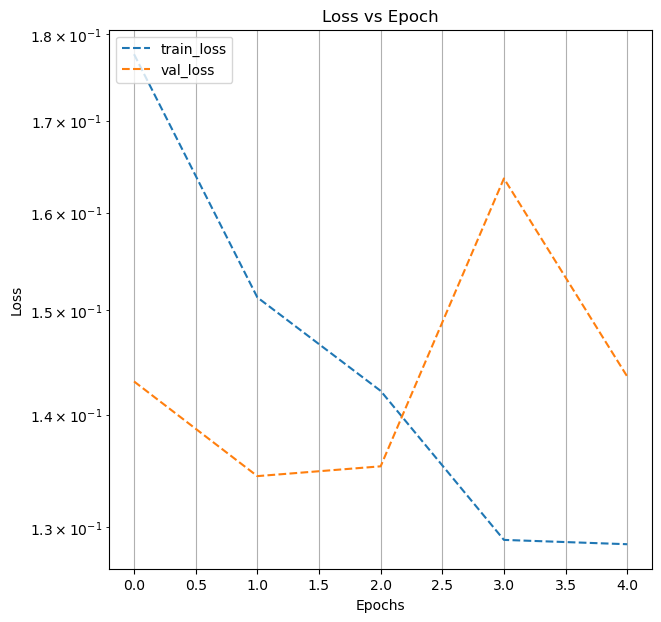

In [190]:
plot_accuracy(model_history)

In [191]:
model_history.history

{'loss': [0.17762494087219238,
  0.15129128098487854,
  0.1422419399023056,
  0.12891842424869537,
  0.12855112552642822],
 'val_loss': [0.14312823116779327,
  0.13445959985256195,
  0.135331392288208,
  0.16364406049251556,
  0.1435941904783249]}

              precision    recall  f1-score   support

           0     1.0000    0.8125    0.8966        32
           1     0.8000    1.0000    0.8889        24

    accuracy                         0.8929        56
   macro avg     0.9000    0.9062    0.8927        56
weighted avg     0.9143    0.8929    0.8933        56



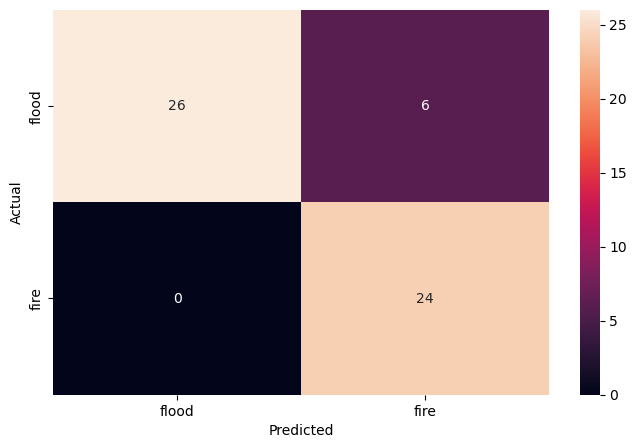

In [192]:
# Evaluate our model based on precision, recall, and f1-score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Printing the classification report
print(classification_report(actual, prediction, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(actual, prediction)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', 
          xticklabels = ['flood', 'fire'],
          yticklabels = ['flood', 'fire'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [193]:
# Create dataset for Disaster Type Classification
actual_df = train_df[(train_df.type == 'fire') | (train_df.type == 'flood') & (train_df.label != 0)].copy()
show_balance(actual_df)

type   label
fire   0        7204
       3        1064
       1          69
       2          43
flood  1         114
       2          97
       3          59
Name: count, dtype: int64

In [194]:
# -1:flood, +1:fire
actual_df['type_code'] = actual_df[['type','label']].apply(lambda df: df['label'] if df['type']=='fire' else -df['label'], axis=1)
actual_df['type_code'] = actual_df['type_code']/actual_df['type_code'].abs().max()

X_actual = actual_df['image'].to_list()
X_actual = np.array([cv2.resize(img, (180, 180)) for img in X_actual])
Y_actual = actual_df['type_code']

In [195]:
prediction = model.predict(X_actual)
prediction = tf.squeeze(custom_activation(prediction)) # sometimes to just want to hug a squeeze your tensors
actual = custom_activation(Y_actual)

271/271 [==============================] - 48s 178ms/step


              precision    recall  f1-score   support

           0     0.9834    0.1187    0.2118      7474
           1     0.1498    0.9872    0.2602      1176

    accuracy                         0.2368      8650
   macro avg     0.5666    0.5530    0.2360      8650
weighted avg     0.8700    0.2368    0.2184      8650



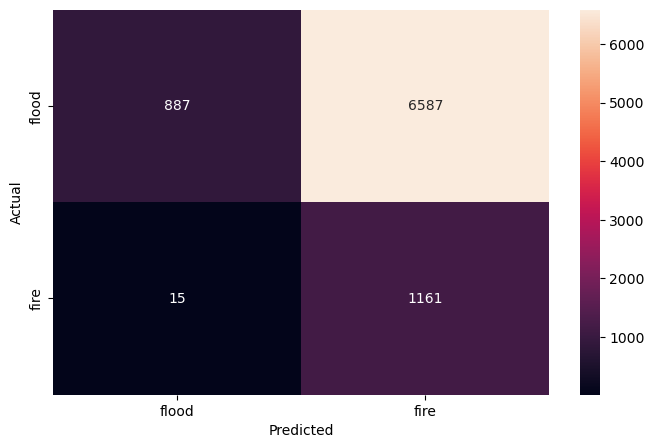

In [196]:
# Evaluate our model based on precision, recall, and f1-score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Printing the classification report
print(classification_report(actual, prediction, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(actual, prediction)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', 
          xticklabels = ['flood', 'fire'],
          yticklabels = ['flood', 'fire'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()